In [1]:
cleaned_data_path = "gs://my-bigdata-project-cf/cleaned/clean_df.parquet"
df_cleaned = spark.read.parquet(cleaned_data_path)

print("Schema:")
df_cleaned.printSchema()
print("\nFirst 5 Rows:")
df_cleaned.show(5)

Schema:
root
 |-- user_id: string (nullable = true)
 |-- review_stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- user_average_stars: double (nullable = true)
 |-- business_stars: double (nullable = true)
 |-- business_review_count: long (nullable = true)
 |-- user_review_count: long (nullable = true)
 |-- business_categories: string (nullable = true)


First 5 Rows:


+--------------------+------------+--------------------+------------------+--------------+---------------------+-----------------+--------------------+
|             user_id|review_stars|                text|user_average_stars|business_stars|business_review_count|user_review_count| business_categories|
+--------------------+------------+--------------------+------------------+--------------+---------------------+-----------------+--------------------+
|--1xed48O2w6o-TLq...|         5.0|On April 29th 201...|               5.0|           4.5|                   79|                3|Beauty & Spas, Pi...|
|--CxEPvaxHHLhjqZE...|         1.0|The worst auto tr...|               1.0|           1.5|                   26|                1|Hotels & Travel, ...|
|--Gz5gj-R1rWq_G_r...|         4.0|I was back home v...|              3.03|           3.5|                  495|               48|Seafood, American...|
|--LUapetRSkZpFZ2d...|         5.0|My family and I h...|              4.91|           4.

In [2]:
#Some rows have more than 1 category so only use the first one
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def first_category(categories):
    return categories.split(", ")[0]

first_category_udf = udf(first_category, StringType())

df_cleaned = df_cleaned.withColumn("business_categories", first_category_udf(df_cleaned.business_categories))

In [3]:
df_cleaned.show()

+--------------------+------------+--------------------+------------------+--------------+---------------------+-----------------+--------------------+
|             user_id|review_stars|                text|user_average_stars|business_stars|business_review_count|user_review_count| business_categories|
+--------------------+------------+--------------------+------------------+--------------+---------------------+-----------------+--------------------+
|--1xed48O2w6o-TLq...|         5.0|On April 29th 201...|               5.0|           4.5|                   79|                3|       Beauty & Spas|
|--CxEPvaxHHLhjqZE...|         1.0|The worst auto tr...|               1.0|           1.5|                   26|                1|     Hotels & Travel|
|--Gz5gj-R1rWq_G_r...|         4.0|I was back home v...|              3.03|           3.5|                  495|               48|             Seafood|
|--LUapetRSkZpFZ2d...|         5.0|My family and I h...|              4.91|           4.

In [4]:
from pyspark.sql.functions import col

#Create features to help evaluate importance of review
df_cleaned = df_cleaned.withColumn("user_reliability_score", col("user_average_stars") / (col("user_review_count") + 1))
df_cleaned = df_cleaned.withColumn("interaction_score", col("user_review_count") * col("business_review_count"))

In [5]:
#  Preprocesses the "business_categories" column into a numerical feature vector
from pyspark.ml.feature import CountVectorizer
from pyspark.sql.functions import split

df_cleaned = df_cleaned.withColumn("category_array", split(col("business_categories"), ", "))
cv = CountVectorizer(inputCol="category_array", outputCol="category_vector", vocabSize=100) 
cv_model = cv.fit(df_cleaned)
df_cleaned = cv_model.transform(df_cleaned)

df_cleaned.select("business_categories", "category_array", "category_vector").show(5, truncate=False)

+-------------------+-----------------+----------------+
|business_categories|category_array   |category_vector |
+-------------------+-----------------+----------------+
|Beauty & Spas      |[Beauty & Spas]  |(100,[13],[1.0])|
|Hotels & Travel    |[Hotels & Travel]|(100,[16],[1.0])|
|Seafood            |[Seafood]        |(100,[7],[1.0]) |
|Bars               |[Bars]           |(100,[3],[1.0]) |
|Beer Gardens       |[Beer Gardens]   |(100,[],[])     |
+-------------------+-----------------+----------------+
only showing top 5 rows



In [6]:
# Delete unneccessary or repetitive columns
df_final = df_cleaned.drop("category_array",'business_categories','text','user_id')

In [7]:
df_final.show(5)

+------------+------------------+--------------+---------------------+-----------------+----------------------+-----------------+----------------+
|review_stars|user_average_stars|business_stars|business_review_count|user_review_count|user_reliability_score|interaction_score| category_vector|
+------------+------------------+--------------+---------------------+-----------------+----------------------+-----------------+----------------+
|         5.0|               5.0|           4.5|                   79|                3|                  1.25|              237|(100,[13],[1.0])|
|         1.0|               1.0|           1.5|                   26|                1|                   0.5|               26|(100,[16],[1.0])|
|         4.0|              3.03|           3.5|                  495|               48|   0.06183673469387755|            23760| (100,[7],[1.0])|
|         5.0|              4.91|           4.0|                  798|               44|   0.10911111111111112|       

In [8]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler
from pyspark.sql.functions import log1p
# Using log transformation columns that can have large values <100 and have heavy skew
df_final = df_final.withColumn("log_business_review_count", log1p(col("business_review_count")))
df_final = df_final.withColumn("log_user_review_count", log1p(col("user_review_count")))
df_final = df_final.withColumn("log_interaction_score", log1p(col("interaction_score")))

In [9]:
# Combine the features into a single "features" column
features_assembled = VectorAssembler(
    inputCols=[
        "user_average_stars", 
        "business_stars", 
        "log_business_review_count", 
        "log_user_review_count", 
        "user_reliability_score", 
        "log_interaction_score", 
        "category_vector"
    ], 
    outputCol="assembled_features"
)
df_final = features_assembled.transform(df_final)

In [10]:
# Min-Max Scaling
scaler = MinMaxScaler(inputCol="assembled_features", outputCol="scaled_features")
scaler_model = scaler.fit(df_final)
df_final = scaler_model.transform(df_final)

In [11]:
df_final.show()

+------------+------------------+--------------+---------------------+-----------------+----------------------+-----------------+----------------+-------------------------+---------------------+---------------------+--------------------+--------------------+
|review_stars|user_average_stars|business_stars|business_review_count|user_review_count|user_reliability_score|interaction_score| category_vector|log_business_review_count|log_user_review_count|log_interaction_score|  assembled_features|     scaled_features|
+------------+------------------+--------------+---------------------+-----------------+----------------------+-----------------+----------------+-------------------------+---------------------+---------------------+--------------------+--------------------+
|         5.0|               5.0|           4.5|                   79|                3|                  1.25|              237|(100,[13],[1.0])|        4.382026634673881|   1.3862943611198906|    5.472270673671475|(106,[0

In [12]:
df_final = df_final.select("scaled_features", "review_stars")

In [13]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create and configure the logistic regression model
train_df, test_df = df_final.randomSplit([0.7, 0.3], seed=42)
lr = LogisticRegression(featuresCol="scaled_features", labelCol="review_stars", maxIter=100, regParam=0.01, elasticNetParam=0.0)
lr_model = lr.fit(train_df)
predictions = lr_model.transform(test_df)

In [14]:
# Evaluation
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="review_stars", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)

precision_evaluator = MulticlassClassificationEvaluator(labelCol="review_stars", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)

recall_evaluator = MulticlassClassificationEvaluator(labelCol="review_stars", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions)

f1_evaluator = MulticlassClassificationEvaluator(labelCol="review_stars", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(predictions)

print(f"Accuracy on test data = {accuracy:.4f}")
print(f"Precision on test data = {precision:.4f}")
print(f"Recall on test data = {recall:.4f}")
print(f"F1 Score on test data = {f1_score:.4f}")

# Confusion matrix
confusion_matrix = predictions.groupBy("review_stars", "prediction").count()
confusion_matrix.show()

Accuracy on test data = 0.5540
Precision on test data = 0.4791
Recall on test data = 0.5540
F1 Score on test data = 0.4794


+------------+----------+------+
|review_stars|prediction| count|
+------------+----------+------+
|         5.0|       1.0| 36513|
|         1.0|       1.0|168302|
|         3.0|       1.0| 23308|
|         1.0|       3.0|   764|
|         3.0|       3.0|   982|
|         5.0|       3.0|   175|
|         1.0|       5.0| 66346|
|         4.0|       3.0|   541|
|         4.0|       1.0| 22985|
|         5.0|       4.0| 64815|
|         2.0|       3.0|   836|
|         1.0|       4.0| 20778|
|         4.0|       4.0|106836|
|         3.0|       4.0| 66243|
|         5.0|       5.0|740236|
|         2.0|       5.0| 62807|
|         3.0|       5.0| 99398|
|         4.0|       5.0|270008|
|         2.0|       4.0| 33417|
|         2.0|       1.0| 49126|
+------------+----------+------+
only showing top 20 rows



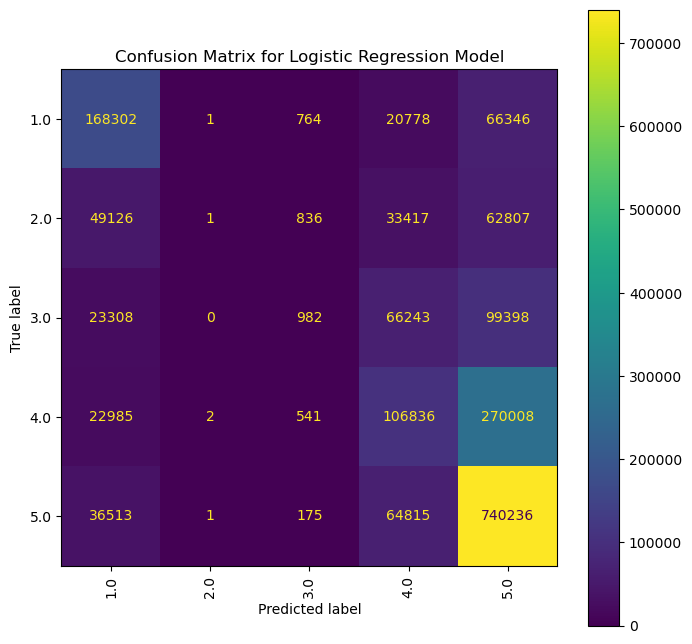

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

predictions_pd = predictions.select("review_stars", "prediction").toPandas()  # Converts to Pandas for sklearn usage

cm = confusion_matrix(predictions_pd["review_stars"], predictions_pd["prediction"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(predictions_pd["review_stars"].unique()))

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='viridis', xticks_rotation='vertical')  # Change color map if you'd like
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()

In [16]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

sample_fraction = 0.15  # Use 15% of the data
sampled_train_df = train_df.sample(fraction=sample_fraction, seed=42)

lr = LogisticRegression(featuresCol="scaled_features", labelCol="review_stars", maxIter=100)

# Define the parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .build()

evaluator = MulticlassClassificationEvaluator(
    labelCol="review_stars", 
    predictionCol="prediction", 
    metricName="accuracy"
)

# Set up cross-validation with K-Folds
crossval = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3 
)

# Perform cross-validation on the sampled data
cv_model = crossval.fit(sampled_train_df)

best_model = cv_model.bestModel
predictions = best_model.transform(test_df) 
final_accuracy = evaluator.evaluate(predictions)

print(f"Final Accuracy on Test Data: {final_accuracy}")

Final Accuracy on Test Data: 0.5539584424731291


In [17]:
path = "gs://my-bigdata-project-cf/Trusted/df_final_features.parquet"
df_final.write.mode("overwrite").parquet(path)

models_path = "gs://my-bigdata-project-cf/Models/lr_model"
lr_model.write().overwrite().save(models_path)

In [18]:
import seaborn as sns
import pandas as pd

predictions_pandas = predictions.select("review_stars", "prediction").toPandas()

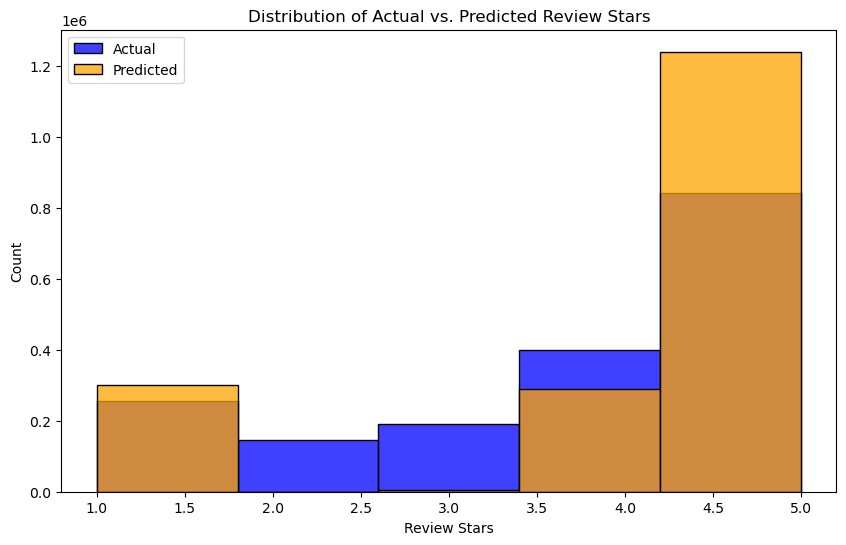

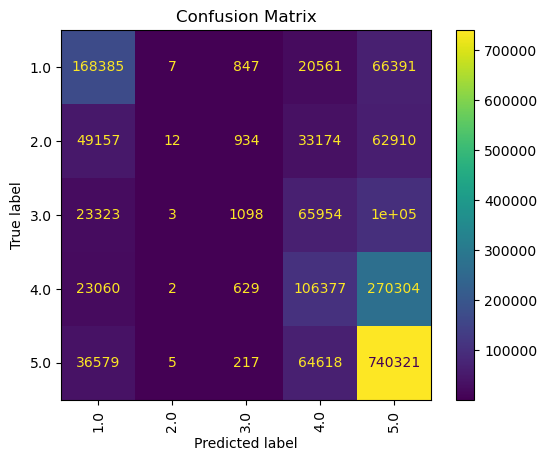

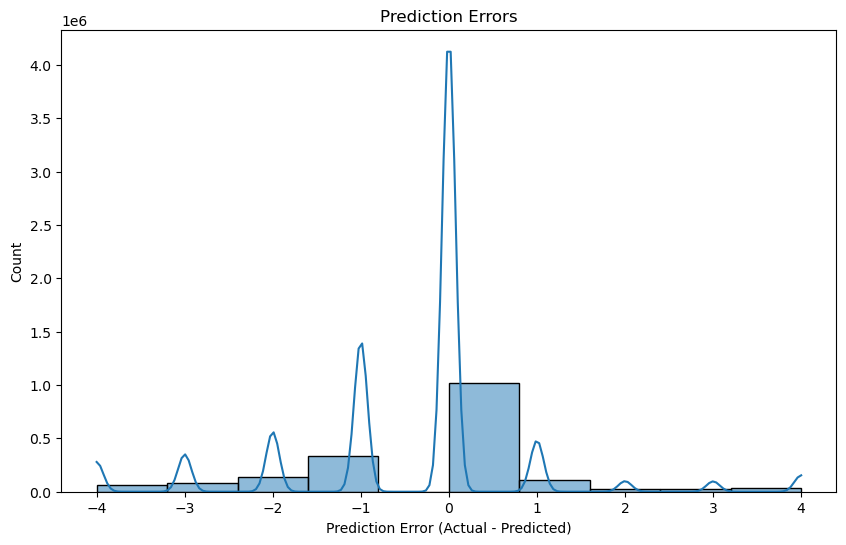

In [19]:
# Visualization 1: Distribution of Review Stars
plt.figure(figsize=(10, 6))
sns.histplot(predictions_pandas["review_stars"], color="blue", label="Actual", kde=False, bins=5)
sns.histplot(predictions_pandas["prediction"], color="orange", label="Predicted", kde=False, bins=5)
plt.xlabel("Review Stars")
plt.ylabel("Count")
plt.title("Distribution of Actual vs. Predicted Review Stars")
plt.legend()
plt.show()

# Visualization 2: Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(predictions_pandas["review_stars"], predictions_pandas["prediction"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(predictions_pandas["review_stars"].unique()))
disp.plot(cmap="viridis", xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()

# Visualization 3: Prediction Errors
predictions_pandas["Error"] = predictions_pandas["review_stars"] - predictions_pandas["prediction"]
plt.figure(figsize=(10, 6))
sns.histplot(predictions_pandas["Error"], bins=10, kde=True)
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Count")
plt.title("Prediction Errors")
plt.show()

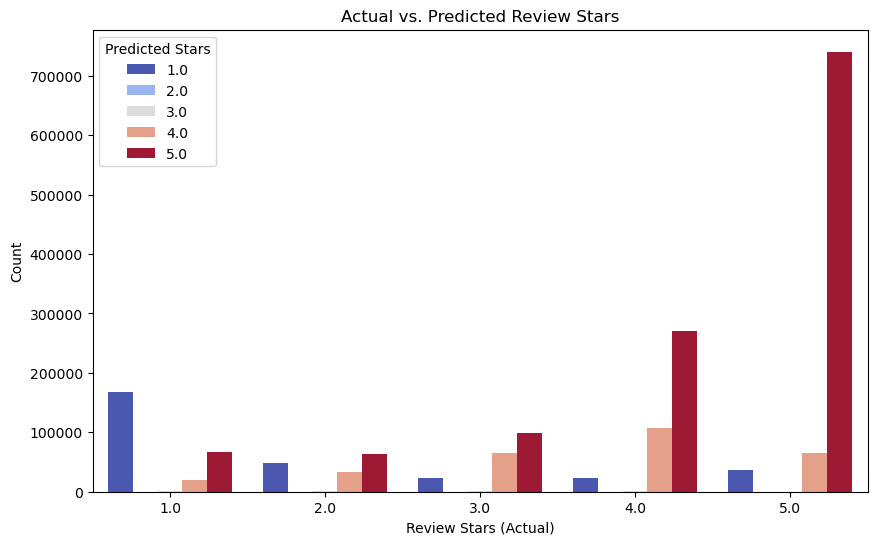

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(data=predictions_pandas, x="review_stars", hue="prediction", palette="coolwarm")
plt.title("Actual vs. Predicted Review Stars")
plt.xlabel("Review Stars (Actual)")
plt.ylabel("Count")
plt.legend(title="Predicted Stars", loc="upper left")
plt.show()

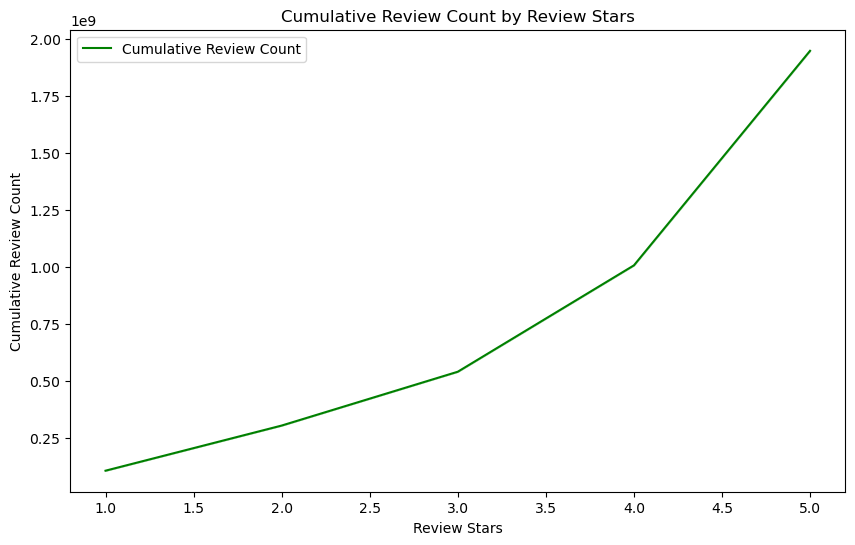

In [21]:
data_pandas = df_cleaned.select("review_stars", "business_review_count").toPandas()

# Sort by review stars and calculate the cumulative sum of business review counts
cumulative_data = data_pandas.sort_values("review_stars")
cumulative_data["cumulative_review_count"] = cumulative_data["business_review_count"].cumsum()

plt.figure(figsize=(10, 6))
sns.lineplot(data=cumulative_data, x="review_stars", y="cumulative_review_count", color="green", label="Cumulative Review Count")
plt.title("Cumulative Review Count by Review Stars")
plt.xlabel("Review Stars")
plt.ylabel("Cumulative Review Count")
plt.legend()
plt.show()

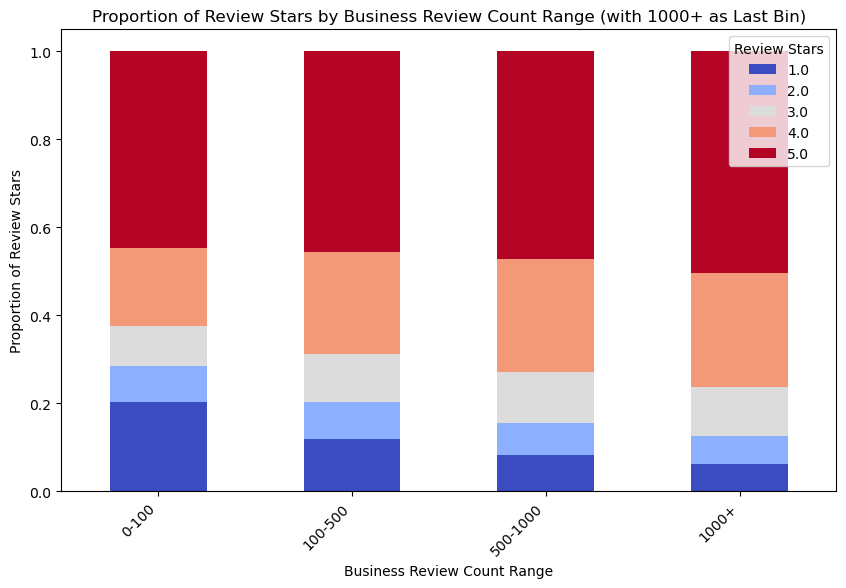

In [22]:
data_pandas = df_cleaned.select("review_stars", "business_review_count").toPandas()

bins = [0, 100, 500, 1000, float('inf')]  
labels = ['0-100', '100-500', '500-1000', '1000+'] 
data_pandas["business_review_count_range"] = pd.cut(data_pandas["business_review_count"], bins=bins, labels=labels, include_lowest=True)

# Create a pivot table to calculate the proportion of review stars in each business review count range
pivot_table = pd.crosstab(index=data_pandas["business_review_count_range"], columns=data_pandas["review_stars"], normalize="index")

pivot_table.plot(kind="bar", stacked=True, figsize=(10, 6), cmap="coolwarm")
plt.title("Proportion of Review Stars by Business Review Count Range (with 1000+ as Last Bin)")
plt.xlabel("Business Review Count Range")
plt.ylabel("Proportion of Review Stars")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Review Stars", loc="upper right")
plt.show()

/tmp/ipykernel_4276/555240220.py:13: FutureWarning:                             

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bin_counts.index, y=bin_counts.values, palette="viridis")


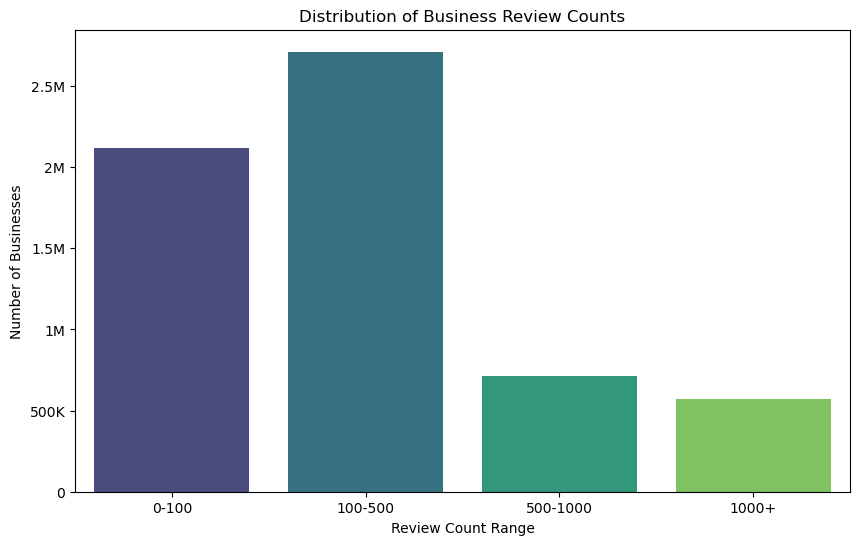

In [23]:
import matplotlib.ticker as mtick

business_review_counts = df_cleaned.select("business_review_count").toPandas()

bins = [0, 100, 500, 1000, float('inf')]
labels = ['0-100', '100-500', '500-1000', '1000+']
business_review_counts['review_count_range'] = pd.cut(business_review_counts['business_review_count'], bins=bins, labels=labels, include_lowest=True)

# Count the number of businesses in each bin
bin_counts = business_review_counts['review_count_range'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=bin_counts.index, y=bin_counts.values, palette="viridis")

plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))  # Format as full numbers (e.g., 500,000)
plt.yticks(ticks=[0, 500_000, 1_000_000, 1_500_000, 2_000_000, 2_500_000], labels=['0', '500K', '1M', '1.5M', '2M','2.5M'])

plt.title("Distribution of Business Review Counts")
plt.xlabel("Review Count Range")
plt.ylabel("Number of Businesses")
plt.show()


/tmp/ipykernel_4276/3100643996.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_stars_by_range = business_review_data.groupby('review_count_range')['business_stars'].mean().reset_index()


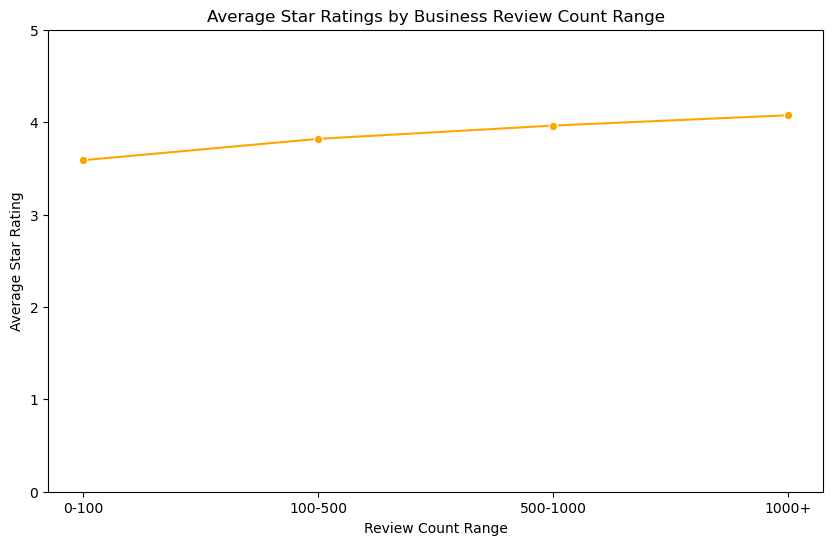

In [24]:
business_review_data = df_cleaned.select("business_review_count", "business_stars").toPandas()

bins = [0, 100, 500, 1000, float('inf')]
labels = ['0-100', '100-500', '500-1000', '1000+']
business_review_data['review_count_range'] = pd.cut(business_review_data['business_review_count'], bins=bins, labels=labels, include_lowest=True)

# Calculate the average star rating for each review count range
average_stars_by_range = business_review_data.groupby('review_count_range')['business_stars'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x=average_stars_by_range['review_count_range'], y=average_stars_by_range['business_stars'], marker='o', color='orange')
plt.title("Average Star Ratings by Business Review Count Range")
plt.xlabel("Review Count Range")
plt.ylabel("Average Star Rating")
plt.ylim(0, 5)
plt.show()


In [26]:
# Reference https://stackoverflow.com/questions/34052115/how-to-find-the-importance-of-the-features-for-a-logistic-regression-model
import numpy as np

# Extract the coefficients matrix from the logistic regression model
coefficients_matrix = lr_model.coefficientMatrix.toArray()

coefficients = np.mean(np.abs(coefficients_matrix), axis=0)  # Take absolute mean for better ranking

feature_cols = [
    "user_average_stars", 
    "business_stars", 
    "log_business_review_count", 
    "log_user_review_count", 
    "user_reliability_score", 
    "log_interaction_score", 
    "category_vector"
]

# Handle category_vector (break into sub-features)
if 'category_vector' in feature_cols:
    category_vector_index = feature_cols.index('category_vector')
    num_category_features = len(coefficients) - (len(feature_cols) - 1)
    category_feature_names = [f'category_{i}' for i in range(num_category_features)]
    feature_cols.pop(category_vector_index)
    feature_cols.extend(category_feature_names)

feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': coefficients
})

# Rank by coefficient importance
feature_importance_df = feature_importance_df.sort_values(by="Coefficient", ascending=False)

print("Most Important Features:")
print(feature_importance_df.head())

Most Important Features:
                  Feature  Coefficient
0      user_average_stars     1.944176
1          business_stars     1.716958
3   log_user_review_count     0.900821
5   log_interaction_score     0.730284
4  user_reliability_score     0.456380
